In [31]:
with open("input.txt", encoding='utf-8') as f:
    text = f.read()

vocab_size = len(set(text))

In [32]:
encoder_map = {c: i for i, c in enumerate(set(text))}
decoder_map = {i: c for i, c in enumerate(set(text))}

encode = lambda x: [encoder_map[c] for c in x]
decode = lambda x: ''.join([decoder_map[i] for i in x])

In [33]:
encode("Test string"), decode(encode("Test string"))

([52, 4, 9, 63, 35, 9, 63, 27, 12, 46, 60], 'Test string')

In [34]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
data[:25]

tensor([49, 12, 27,  9, 63, 35, 57, 12, 63, 12, 41,  4, 46, 33, 42, 11,  4,  3,
        56, 27,  4, 35, 32,  4, 35])

In [35]:
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


In [36]:
split = int(len(data) * 0.8)
train_data, val_data = data[:split], data[split:]

In [37]:
torch.manual_seed(2115)
batch_size = 32
seq_len = 64
n_embed = 64
num_heads = 8

def get_batches(mode):
    bath_data = train_data if mode == 'train' else val_data
    idx = torch.randint(0, len(bath_data) - seq_len, (batch_size,))
    x = torch.stack([bath_data[i:i + seq_len] for i in idx])
    y = torch.stack([bath_data[i + 1:i + seq_len + 1] for i in idx])
    return x, y


xb, yb = get_batches('train')

In [38]:
import torch.nn as nn
from torch.nn import functional as F


class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(seq_len, seq_len)))
        self.head_size = head_size
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        weights = q @ k.transpose(-1, -2) * C ** -0.5
        weights = weights.masked_fill(self.tril[:T, : T] == 0, float('-inf'))
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        return weights @ v

In [39]:
class MultiHead(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

In [40]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size),
            nn.ReLU(),
            nn.Linear(4 * hidden_size, hidden_size),
            nn.Dropout(0.1),
        )

    def forward(self, x):
        return self.net(x)

In [41]:
class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa_heads = MultiHead(n_head, head_size)
        self.feed_forward = FeedForward(n_embed)
        self.layer_norm1 = nn.LayerNorm(n_embed)
        self.layer_norm2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa_heads(self.layer_norm1(x))
        x = x + self.feed_forward(self.layer_norm2(x))
        return x

In [42]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(seq_len, n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed, num_heads) for _ in range(6)])
        self.layer_norm = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        token_embedding = self.token_embedding_table(idx)
        position_embedding = self.position_embedding_table(torch.arange(T))
        x = token_embedding + position_embedding
        x = self.blocks(x)
        x = self.layer_norm(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, n):
        for _ in range(n):
            idx_crop = idx[:, -seq_len:]
            logits, _ = self(idx_crop)
            logits = logits[:, -1, :]
            p = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(p, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx

In [43]:
m = BigramLanguageModel()

In [44]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batches(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [45]:
import os

def notify_end_of_cell(message="Cell execution completed!"):
    os.system(f'notify-send "Jupyter Cell Notification" "{message}"')

In [50]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.0003)

history = []
eval_interval = 25
max_iter = 1000
for iter in range(max_iter):

    if iter % eval_interval == 0:
        losses = estimate_loss(m)
        history.append((iter, losses))
        print(f'Iter {iter}, train loss: {losses["train"]:.3f}, val loss: {losses["val"]:.3f}')

    x, y = get_batches('train')
    logits, loss = m(x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())
notify_end_of_cell()

Iter 0, train loss: 1.992, val loss: 2.061
Iter 25, train loss: 1.988, val loss: 2.062
Iter 50, train loss: 1.985, val loss: 2.059
Iter 75, train loss: 1.981, val loss: 2.055
Iter 100, train loss: 1.980, val loss: 2.053
Iter 125, train loss: 1.978, val loss: 2.050
Iter 150, train loss: 1.977, val loss: 2.049
Iter 175, train loss: 1.975, val loss: 2.051
Iter 200, train loss: 1.975, val loss: 2.052
Iter 225, train loss: 1.966, val loss: 2.044
Iter 250, train loss: 1.961, val loss: 2.047
Iter 275, train loss: 1.959, val loss: 2.039
Iter 300, train loss: 1.967, val loss: 2.044
Iter 325, train loss: 1.960, val loss: 2.039
Iter 350, train loss: 1.956, val loss: 2.039
Iter 375, train loss: 1.950, val loss: 2.040
Iter 400, train loss: 1.946, val loss: 2.032
Iter 425, train loss: 1.949, val loss: 2.038
Iter 450, train loss: 1.942, val loss: 2.031
Iter 475, train loss: 1.944, val loss: 2.030
Iter 500, train loss: 1.942, val loss: 2.026
Iter 525, train loss: 1.926, val loss: 2.017
Iter 550, train

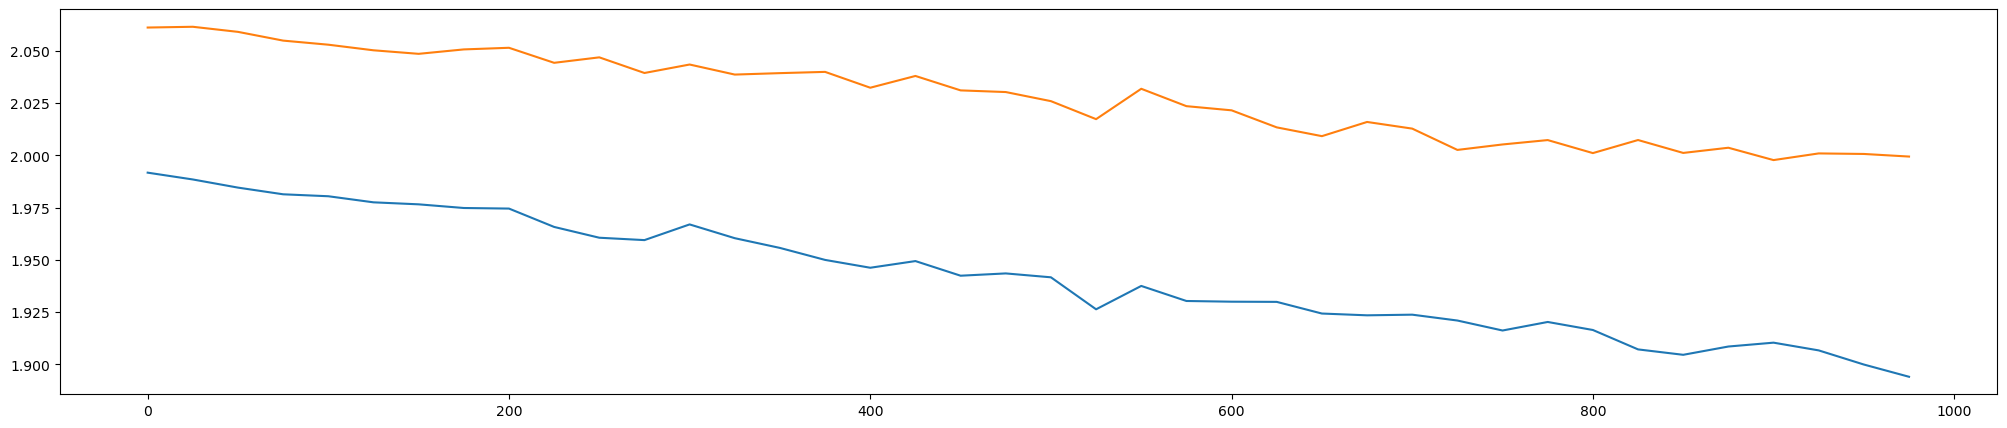

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 5))

x = [h[0] for h in history]
y = [h[1]['train'] for h in history]
y_val = [h[1]['val'] for h in history]
plt.plot(x, y, label='train')
plt.plot(x, y_val, label='val')

In [52]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(m.generate(idx, 1000)[0].tolist()))

Gomesfur. whe ill let heaves,
Thou ener ong: comeq thaves condy wrome you,
Bs wiffory drieth, re hizede is wilieng,
My baridiel,-rourh, that my or Mordow somes!
So sent, Ipom, den trogine an, puce!
A of thine han to upore deeak thath sharty and.


GLEEXENTER:
Were-ZErd:
I't, he coust a to seen so bee; ait!

AULAPY:
I tand age as fuer, yor heaves bee pamath form?
Whit shere is of heare; paigitsine-that.

QUEESS:
It, my Gongh, thollling hap as ond thos as lugmmann thing wruce manein
Browed upp boioriad.

IO! Cays to they a dewas that.

NRUSES:
Welike? zit, methal, so shous bak 've nan quee met
Whoulce peectar to trowe we corriom:
If ather, thou why! a sdaitt se curce.

KIth:-hise eckele st, are forse that nerses.

ERYO:
Alle,
Fere don he--purtions.

SEDWARLO:
Itcoly the whill or canat, me up himbr.

JUCETENES:
Mard reloar thous hon-fess 
Thave mase thak too ghatne, I knoce thin
And were but froch it in is ith huses, to neee,
The hiclcepe of an Meeceanctan on a yof borde that
Frrim Egh
Bo

In [53]:
torch.save(m.state_dict(), 'models/parallel_checkpoints_64_2.pth')